# Introduction

In the first portion of this assignment 3 walkthrough, we rely on a popular NLP library [spaCy](https://spacy.io/) to create knowledge graphs.

In order to do this, we use the gramatical rules about sentence composition encoded in spaCy.

We begin by downloading the English lexicon.


In [1]:
! python -m spacy download en_core_web_lg

2023-11-27 03:36:10.684019: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-27 03:36:10.684095: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-27 03:36:10.684159: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-27 03:36:10.697092: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-27 03:36:14.460643: W tensorflow/compiler/

We will use the [networkx](https://networkx.org/) library to plot the knowledge graphs created for the movie reviews.

In [2]:
import spacy

import networkx as nx
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from spacy.matcher import Matcher

from tqdm import tqdm

In [3]:
sns.set_context('talk')

In [4]:
# Sometimes the path of the downloaded spacy model doesn't get picked on Colab
# This cell needs to be executed in such situations
# Use this only if spacy.load(...) is failing in the next step

import spacy.cli

#spacy.cli.download("en_core_web_lg")

In [5]:
nlp = spacy.load('en_core_web_lg')

In [6]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)

def get_corpus_df(path):
    data = pd.read_csv(path, encoding="utf-8")
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

# Data

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')
CORPUS_PATH=\
'gdrive/MyDrive/Colab Notebooks/MSDS453/A3/Dereferenced_Assignment3_v2.csv'
class_corpus = get_corpus_df(CORPUS_PATH)

Mounted at /content/gdrive


In [8]:
class_corpus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 152 to 159
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DSI_Title                 10 non-null     object
 1   Text                      10 non-null     object
 2   Submission File Name      10 non-null     object
 3   Student Name              10 non-null     object
 4   Genre of Movie            10 non-null     object
 5   Review Type (pos or neg)  10 non-null     object
 6   Movie Title               10 non-null     object
 7   Descriptor                10 non-null     object
 8   Modified_Text             10 non-null     object
 9   Doc_ID                    10 non-null     int64 
dtypes: int64(1), object(9)
memory usage: 880.0+ bytes


In [9]:
class_corpus.Modified_Text.head()

Doc_ID
152    A tedious rip-off sci-fi film, itching to be a...
155    '``Equilibrium'' is like a remake of ``1984'' ...
156    An unsophisticated sci-fi drama that takes its...
157    Science fiction is a good genre for creating v...
158    The worst theatrically released sci-fi flick s...
Name: Modified_Text, dtype: object

In [10]:
class_corpus['Movie Title'].value_counts()

EQUILIBRIUM    10
Name: Movie Title, dtype: int64

Creation of knowledge graphs rests on two crucial ingredients.  
- entities that represent specific concepts
- relations that connect different concepts

Translated into the rules of English, [the hypothesis](https://www.kaggle.com/code/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk/notebook) is that for each sentence:
 - entities are the subject and object in the sentence
 - verbs encode the relation between the entities in the sentence
 - entities could be compound words (e.g., phrases)  

In [11]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " " + tok.text

      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " " + tok.text

      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier + " " + prefix + " " + tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier + " " + prefix + " " + tok.text

      ## chunk 5
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

def get_relation(sent):
    try:
        doc = nlp(sent)

        # Matcher class object
        matcher = Matcher(nlp.vocab)

        #define the pattern
        pattern = [{'DEP':'ROOT'},
                   {'DEP':'prep', 'OP':"?"},
                   {'DEP':'agent', 'OP':"?"},
                   {'POS':'ADJ', 'OP':"?"}]

        matcher.add("matching_1", [pattern])
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]]

        return(span.text)
    except Exception as e:
        pass

def get_subject_verb_object(sent):
  ent1 = ""
  ent2 = ""
  root = ""

  for tok in nlp(sent):
      if tok.dep_ == 'ROOT':
        root = tok.text
      elif tok.dep_ == "nsubj":
        ent1 = tok.text
      elif tok.dep_ == "dobj":
        ent2 = tok.text

      if ent1 != '' and ent2 != '' and root != '':
        break

  return [ent1, root, ent2]

As the above code listing indicates, we use spaCy's grammatical annotations for the tokens (indicated by `dep_`) to identify the relevant parts of speech.

In [12]:
spacy.explain('agent')

'agent'

For this part of the assignment, we work on a set of reviews for one movie.

In [13]:
MOVIE_TO_EXPLORE = 'EQUILIBRIUM'

In [14]:
movie_reviews = (class_corpus.loc[class_corpus['Movie Title'] == MOVIE_TO_EXPLORE, 'Modified_Text']
                             .reset_index(drop=True))

# Example Review

Let us see how the entity and relation functions work on an example sentence from the set of 10 reviews.

## Explore entities & relations

In [15]:
movie_reviews

0    A tedious rip-off sci-fi film, itching to be a...
1    '``Equilibrium'' is like a remake of ``1984'' ...
2    An unsophisticated sci-fi drama that takes its...
3    Science fiction is a good genre for creating v...
4    The worst theatrically released sci-fi flick s...
5    'Equilibrium' is my favorite movie of 2002. 'E...
6    If I was to explain this movie to someone in o...
7    If you were disappointed by recent sci-fi acti...
8    'Equilibrium' would be a mindless action pictu...
9    In the first years of the 21st century, a thir...
Name: Modified_Text, dtype: object

In [16]:
movie_reviews[1]

"'``Equilibrium'' is like a remake of ``1984'' by someone who's seen ``The Matrix'' 25 times while eating Twinkies and doing methamphetamines. The movie 'Equilibrium' is set in someone's zany idea of a future totalitarian state where guys in black leather are burning all the poetry but haven't gotten around to picking up the machine guns yet. As Keanu Reeves might say, whoa! Boasting a handsome if over-digitized production and a bevy of male beauties as central characters (there's a big cheekbone thing going on here), the movie 'Equilibrium' has evolved at least one degree from the dystopian broodings of Orwell. The central conceit of 'Equilibrium' is based on antidepressants that weren't around in Orwell's day. In this future, the central conceit of 'Equilibrium' (taking the place of 'it') is law that every day in every way, every citizen must take an injection of the drug Prozium, which reduces humankind to an efficient if narcoticized half-life. In exchange for this miasma of stupor

In [17]:
doc = nlp(movie_reviews[1])

Passing a review through the `nlp` pipeline from `spaCy` automatically generates a set of sentences in the review. This is accessed by the attribute `sents`.

In [18]:
list(doc.sents)

['``Equilibrium'' is like a remake of ``1984'' by someone who's seen ``The Matrix'' 25 times while eating Twinkies and doing methamphetamines.,
 The movie 'Equilibrium' is set in someone's zany idea of a future totalitarian state where guys in black leather are burning all the poetry but haven't gotten around to picking up the machine guns yet.,
 As Keanu Reeves might say, whoa!,
 Boasting a handsome if over-digitized production and a bevy of male beauties as central characters (there's a big cheekbone thing going on here), the movie 'Equilibrium' has evolved at least one degree from the dystopian broodings of Orwell.,
 The central conceit of 'Equilibrium' is based on antidepressants that weren't around in Orwell's day.,
 In this future, the central conceit of 'Equilibrium' (taking the place of 'it') is law that every day in every way, every citizen must take an injection of the drug Prozium, which reduces humankind to an efficient if narcoticized half-life.,
 In exchange for this mias

In [19]:
doc_sents = [str(x) for x in list(doc.sents)]

Let us pick the first sentence to observe how the entity-relation extraction works.

In [20]:
example_sent = doc_sents[0]

In [21]:
example_sent

"'``Equilibrium'' is like a remake of ``1984'' by someone who's seen ``The Matrix'' 25 times while eating Twinkies and doing methamphetamines."

Vanilla application of the `get_subject_verb_object` function does not yield a good result since theer could be compound entities.

In [22]:
get_subject_verb_object(example_sent)

['Equilibrium', 'is', 'Twinkies']

Passing the example sentence to the `nlp` pipeline extracts the parts of speech in the sentence.

In [23]:
example_nlp = nlp(example_sent)

In [24]:
for tok in example_nlp:
    print(tok.dep_)

punct
punct
punct
nsubj
punct
ROOT
prep
det
pobj
prep
punct
punct
pobj
punct
prep
pobj
nsubjpass
auxpass
relcl
punct
punct
det
oprd
punct
nummod
npadvmod
mark
advcl
dobj
cc
conj
dobj
punct


In [25]:
spacy.explain('punct')

'punctuation'

In [26]:
get_entities(example_sent)

['who', 'times  methamphetamines']

In [27]:
get_relation(example_sent)

'is like'

We can now parse through all the sentences in the review and extract the entities and relations.

In [28]:
entity_pairs = []

for i in tqdm(doc_sents):
  entity_pairs.append(get_entities(i))

100%|██████████| 16/16 [00:00<00:00, 41.14it/s]


In [29]:
entity_pairs

[['who', 'times  methamphetamines'],
 ['where  guys', 'around machine guns'],
 ['Keanu Reeves', ''],
 ['here  movie', 'dystopian  Orwell'],
 ['that', 'around  day'],
 ['drug which', 'half  life'],
 ['messy  what', 'crime'],
 ['far Cloud art', '! movie criticism'],
 ['reigning stud pups', 'future'],
 ['armed  dissenters', 'noted Henry Wadsworth Longfellow'],
 ['9.8 cheekbone who', 'killing Manley Hopkins AK-47s'],
 ['for  I', 'Hermann Hesse'],
 ['love  sentimentality', 'him'],
 ['great John Preston', 'deviant  impulses'],
 ['new John partner', '9.3 cheekbone him'],
 ['18 John Preston', 'love']]

In [30]:
relations = [get_relation(i) for i in tqdm(doc_sents)]

100%|██████████| 16/16 [00:00<00:00, 42.45it/s]


In [31]:
relations

['is like',
 'set in',
 'say',
 'evolved',
 'based on',
 'is',
 'enjoy',
 'banned',
 'are',
 'raid underground',
 'turns on',
 'know',
 'come over',
 'regrets',
 'beginning',
 'falling in']

To visualize the knowledge graph we create a data frame with the source and target mapped out with the relationship between them (referred to as an edge-list).

In [32]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source': source,
                      'target': target,
                      'edge': relations})

In [33]:
# create a directed-graph from a dataframe
G = nx.from_pandas_edgelist(kg_df, "source", "target",
                            edge_attr=True,
                            create_using=nx.MultiDiGraph())

Knowledge graph for one review.

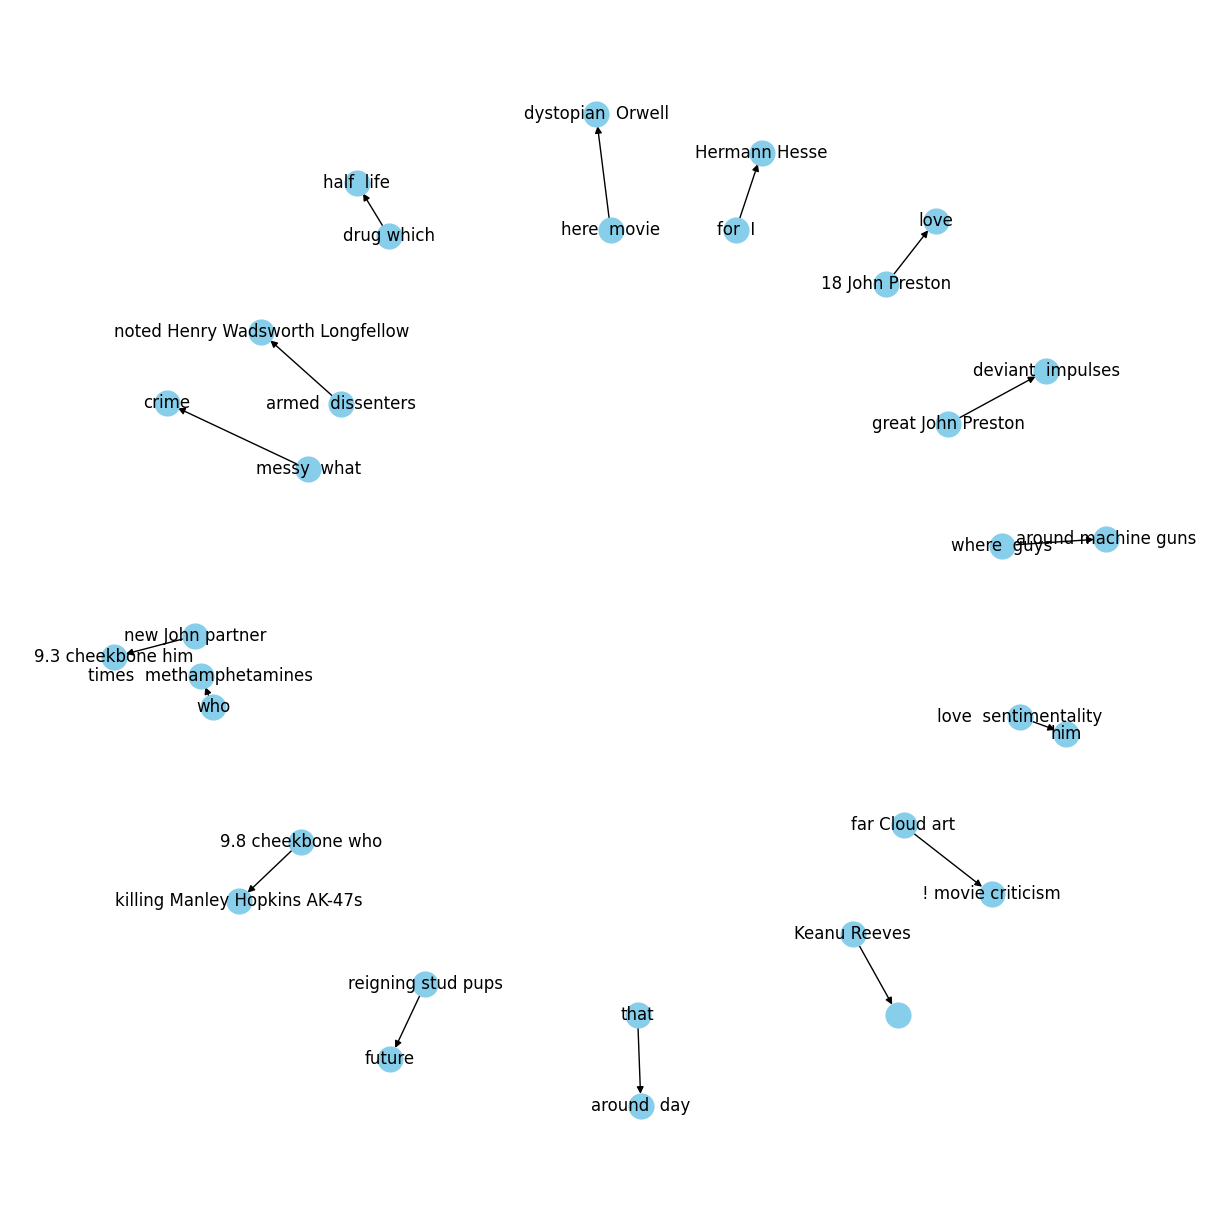

In [34]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)

nx.draw(G, with_labels=True,
        node_color='skyblue',
        edge_cmap=plt.cm.Blues,
        pos=pos)

plt.show()

# All Reviews

So far we have worked with one review. We can now roll out the same method to plot the knowledge graph for the 10 reviews collected for the chosen movie.

## Explore entities and relations

In [35]:
movie_reviews

0    A tedious rip-off sci-fi film, itching to be a...
1    '``Equilibrium'' is like a remake of ``1984'' ...
2    An unsophisticated sci-fi drama that takes its...
3    Science fiction is a good genre for creating v...
4    The worst theatrically released sci-fi flick s...
5    'Equilibrium' is my favorite movie of 2002. 'E...
6    If I was to explain this movie to someone in o...
7    If you were disappointed by recent sci-fi acti...
8    'Equilibrium' would be a mindless action pictu...
9    In the first years of the 21st century, a thir...
Name: Modified_Text, dtype: object

Conceptually, this is no different from working on one review, we simply join all the reviews for the movie into one large string.

In [36]:
all_movie_reviews = ' '.join(movie_reviews)

In [37]:
doc = nlp(all_movie_reviews)

In [38]:
doc_sents = [str(x) for x in doc.sents]

First sentence

In [39]:
doc_sents[0]

"A tedious rip-off sci-fi film, itching to be another Matrix (or, maybe just a bearable flick!), that brazenly steals everything from Orwell's 1984 novel and many other thinking man's films, with the same Dystopian agenda, such as Fahrenheit 451."

Last sentence

In [40]:
doc_sents[-1]

'To counter these familiar ideas, there are also a few new concepts.'

In [41]:
len(doc_sents)

174

In [42]:
entity_pairs = []

for i in tqdm(doc_sents):
  entity_pairs.append(get_entities(i))

100%|██████████| 174/174 [00:04<00:00, 39.47it/s]


In [43]:
relations = [get_relation(i) for i in tqdm(doc_sents)]

100%|██████████| 174/174 [00:04<00:00, 37.68it/s]


In [44]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

In [45]:
# Move everything to lower case
kg_df.source = kg_df.source.str.lower()
kg_df.target = kg_df.target.str.lower()
kg_df.edge = kg_df.edge.str.lower()

# Filter out empties
kg_df = kg_df[kg_df.source != '']
kg_df = kg_df[kg_df.target != '']
kg_df = kg_df[kg_df.edge != ''].copy()

In [46]:
kg_df.shape

(156, 3)

In [47]:
# create a directed-graph from a dataframe
G = nx.from_pandas_edgelist(kg_df, "source", "target",
                            edge_attr=True, create_using=nx.MultiDiGraph())

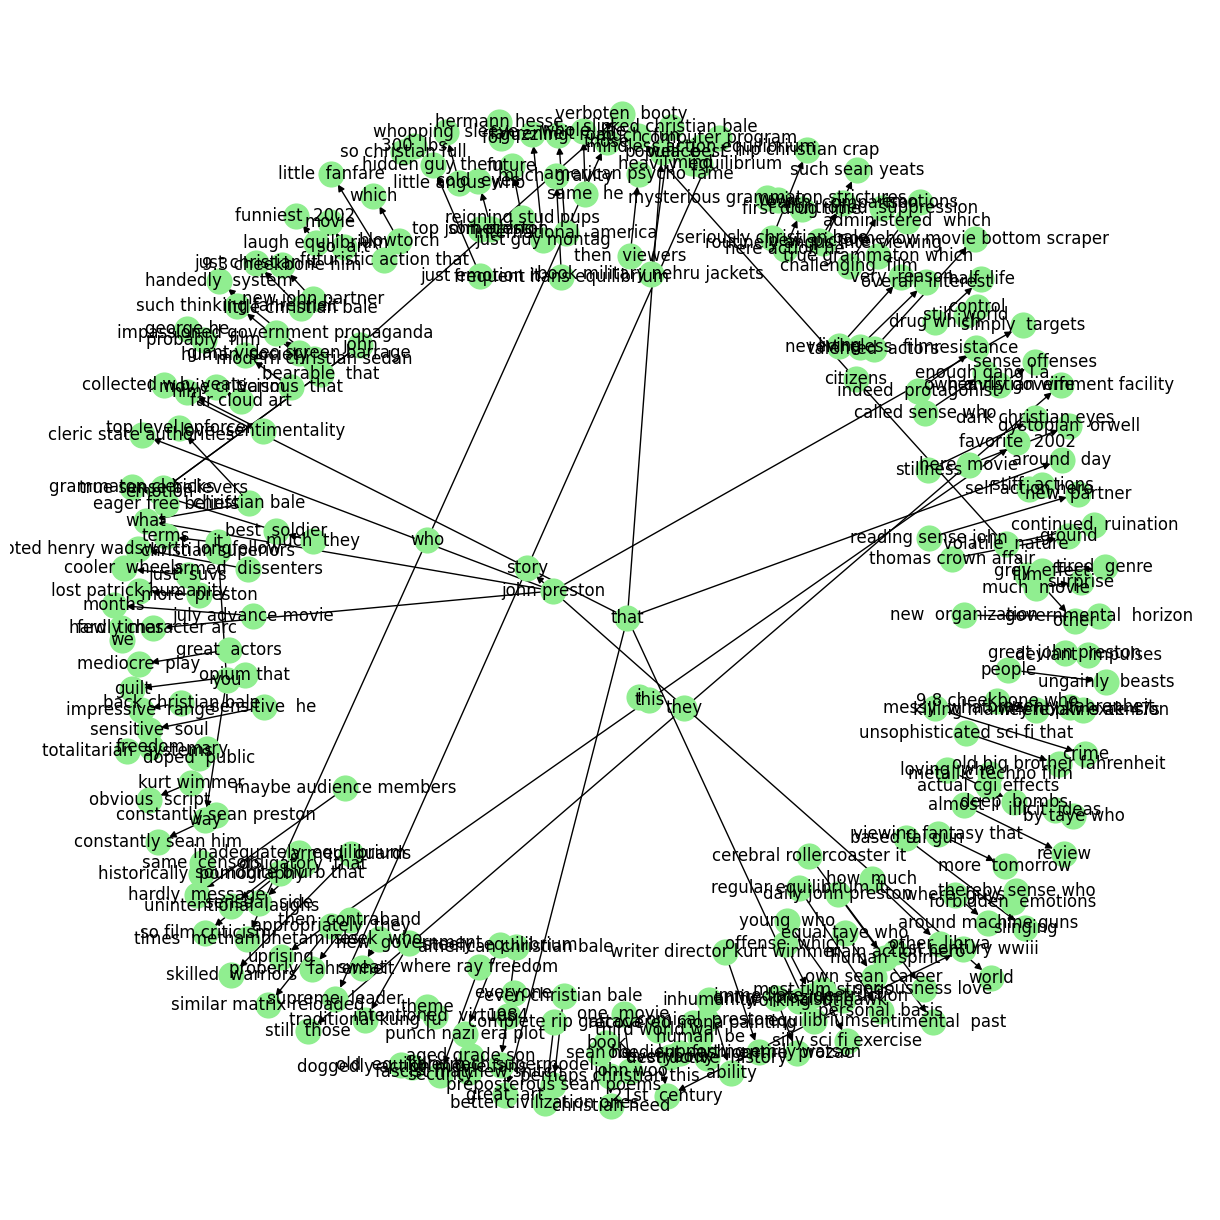

In [48]:

plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)

nx.draw(G, with_labels=True,
        node_color='lightgreen',
        edge_cmap=plt.cm.Blues,
        pos=pos)

plt.show()

## Interesting relations

There are several relations to explore in the plot from the previous section. We could choose to focus on some relations that we find are particularly interesting.

In [49]:
pd.Series(relations).value_counts()[:50]

is                     24
are                     7
has                     6
was                     4
know                    3
be                      2
say                     2
set in                  2
have                    2
portrays                2
takes                   2
stops                   1
frightened by           1
decided                 1
suppose                 1
employed by special     1
went to                 1
deals with              1
notice                  1
seem                    1
Is                      1
hey                     1
sticks                  1
forgets                 1
made                    1
at                      1
surprised by            1
plays                   1
plagued with            1
is obvious              1
killed                  1
sit in                  1
keep                    1
remembers               1
patrol                  1
given                   1
controlled by           1
's                      1
steals      

We could zoom in on interesting relations from the list above.

In [50]:
RELATION_TO_EXPLORE = 'is'

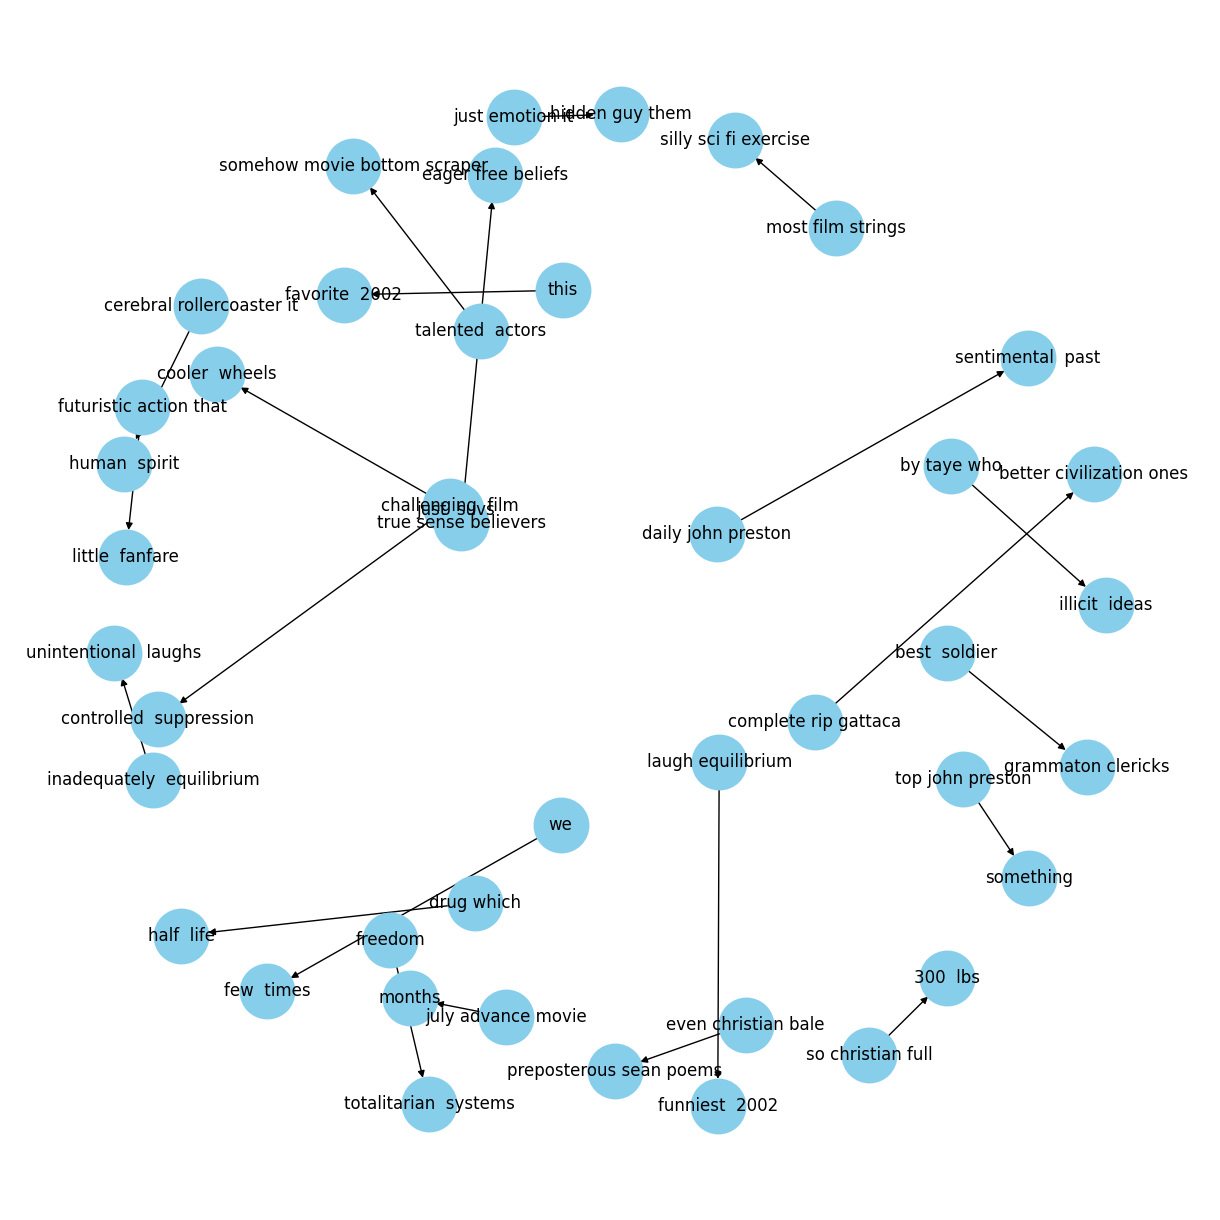

In [51]:
G = nx.from_pandas_edgelist(kg_df[kg_df['edge'] == RELATION_TO_EXPLORE],
                            "source", "target",
                            edge_attr=True,
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes

nx.draw(G, with_labels=True,
        node_color='skyblue',
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()

## Interesting entities

Similary, we could zoom in on interesting entitites (say those identified from the manual ontology creation).

In [52]:
pd.set_option('display.max_rows', 500)
all_entities = kg_df['source'].tolist() + kg_df['target'].tolist()
frequency_count = pd.Series(all_entities).value_counts()

In [53]:
frequency_count

john preston                         6
that                                 5
equilibrium                          4
it                                   3
john                                 3
story                                3
this                                 3
you                                  2
emotions                             2
christian bale                       2
21st  century                        2
what                                 2
something                            2
who                                  2
citizens                             2
best  soldier                        2
film                                 2
emotion                              2
they                                 2
whopping  sleeve                     1
hip christian crap                   1
great  art                           1
world                                1
hidden guy them                      1
killer tech supermodel               1
somehow movie bottom scra

In [54]:
print(len(frequency_count))

280


Text(0, 0.5, 'Number of Entities')

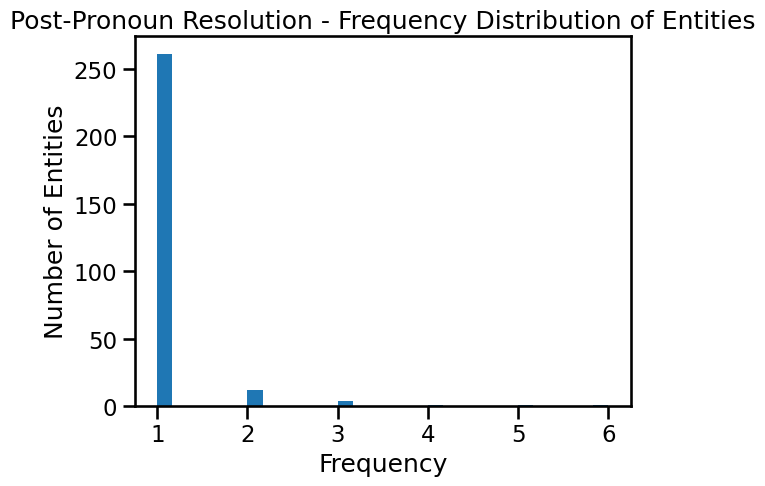

In [55]:
plt.hist(frequency_count, bins=30)
plt.title('Post-Pronoun Resolution - Frequency Distribution of Entities')
plt.xlabel('Frequency')
plt.ylabel('Number of Entities')

In [56]:
ENTITY_TO_EXPLORE = 'john preston'

In [57]:
entity_filter = (kg_df['source'] == ENTITY_TO_EXPLORE) | (kg_df['target'] == ENTITY_TO_EXPLORE)

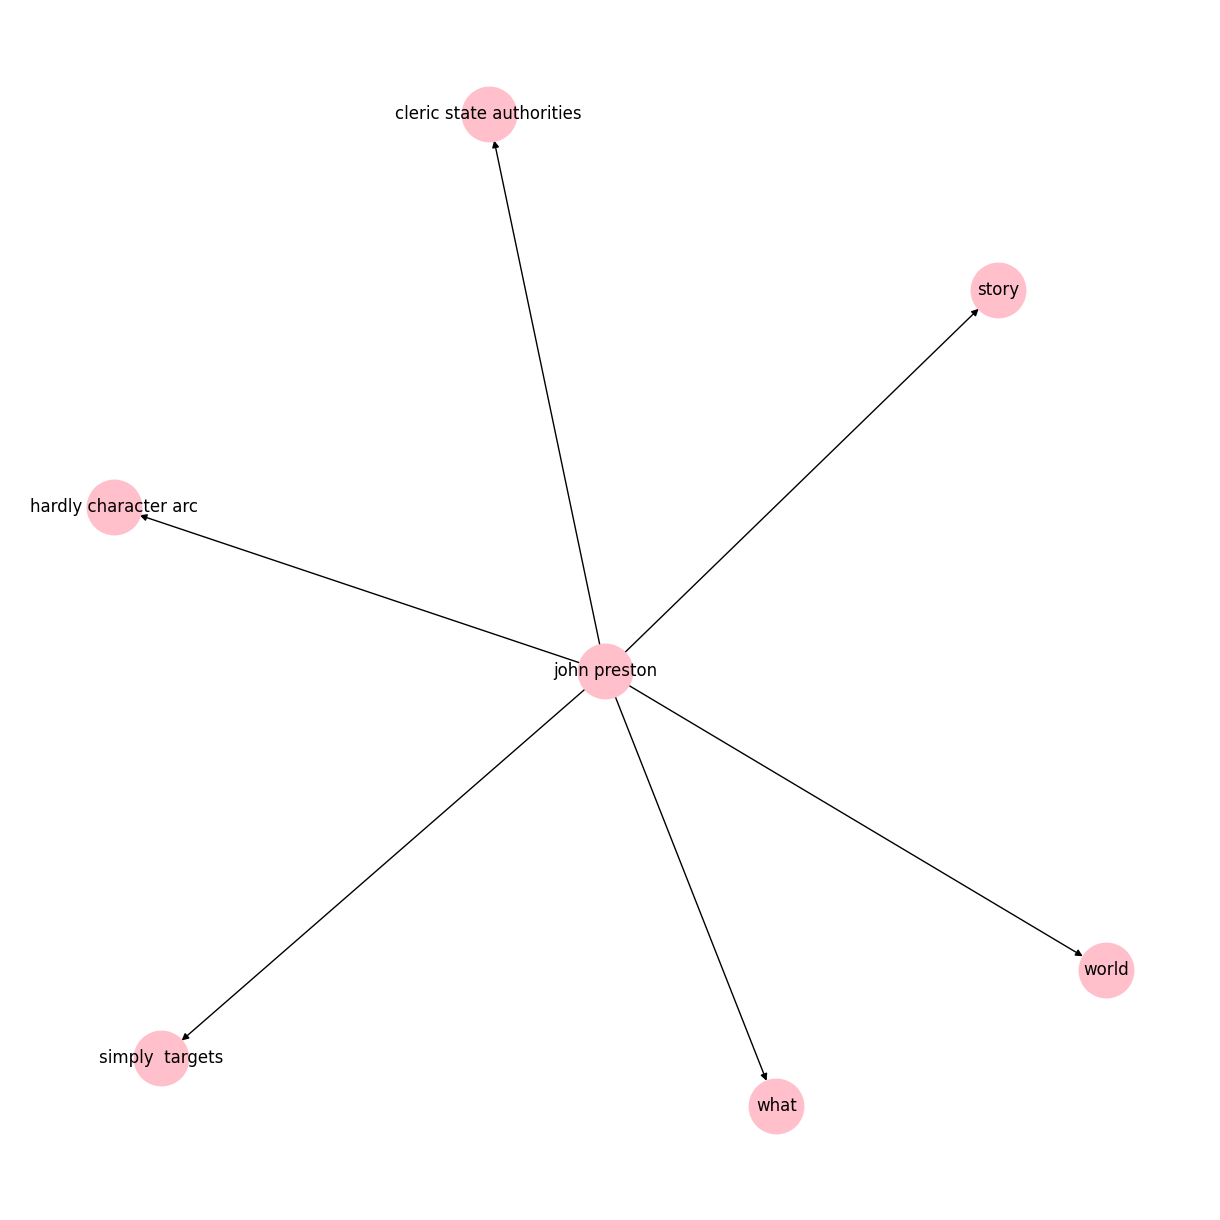

In [58]:


G = nx.from_pandas_edgelist(kg_df[entity_filter],
                            "source", "target",
                            edge_attr=True,
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes

nx.draw(G, with_labels=True,
        node_color='pink',
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()

In [59]:
def investigate_kg_entities(kg_df, entities_to_explore):
    entities_filter = (kg_df['source'].isin(entities_to_explore)) | (kg_df['target'].isin(entities_to_explore))
    G = nx.from_pandas_edgelist(new_kg_df[entities_filter],
                            "source", "target",
                            edge_attr=True,
                            create_using=nx.MultiDiGraph())

    plt.figure(figsize=(12, 12))

    pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes

    nx.draw(G, with_labels=True,
            node_color='pink',
            node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

    plt.show()

In [70]:
new_kg_df = kg_df.copy()
term_mapper = {'john preston': ['john preston', 'john', 'preston'],
               'christian bale': ['christian', 'bale'],
               'mona lisa': ['mona', 'lisa', 'mona-lisa', 'mona lisa', 'painting', 'art'],
               'equilibrium' : ['equilibrium', 'movie', 'film'],
               'kurt wimmer' : ['kurt wimmer', 'kurt', 'wimmer'],
               'grammaton cleric authority' : ['cleric', 'grammaton', 'authority', 'authorities'],
               'prozium': ['prozium', 'drug', 'opium'],
               'emotions': ['emotion', 'emotions'],
               'mary obrien': ['mary', 'obrien', 'mary obrien'],
               '2002': ['2002'],
               '21st century': ['21st'],
               'world war iii': ['wwiii', 'world war', 'ww','iii'],
               'fahrenheit': ['fahrenheit'],
               'sense offender': ['sense', 'offense', 'offender'],
               'scifi': ['sci-fi', 'scifi', 'sci fi'],
               'wb yeats': ['yeats', 'w.b.'],
               'emily watson': ['emily', 'watson']
               }

# Function to apply replaceme drugnts based on substring matches
def replace_substring(cell, term_mapper):
    for key, values in term_mapper.items():
        for value in values:
            if value in cell:
              if value == 'john' and 'woo' in cell:
                return cell
              else:
                return key
    return cell

# Apply replacements for 'source' column
new_kg_df['source'] = new_kg_df['source'].apply(lambda x: replace_substring(x, term_mapper))

# Apply replacements for 'target' column
new_kg_df['target'] = new_kg_df['target'].apply(lambda x: replace_substring(x, term_mapper))

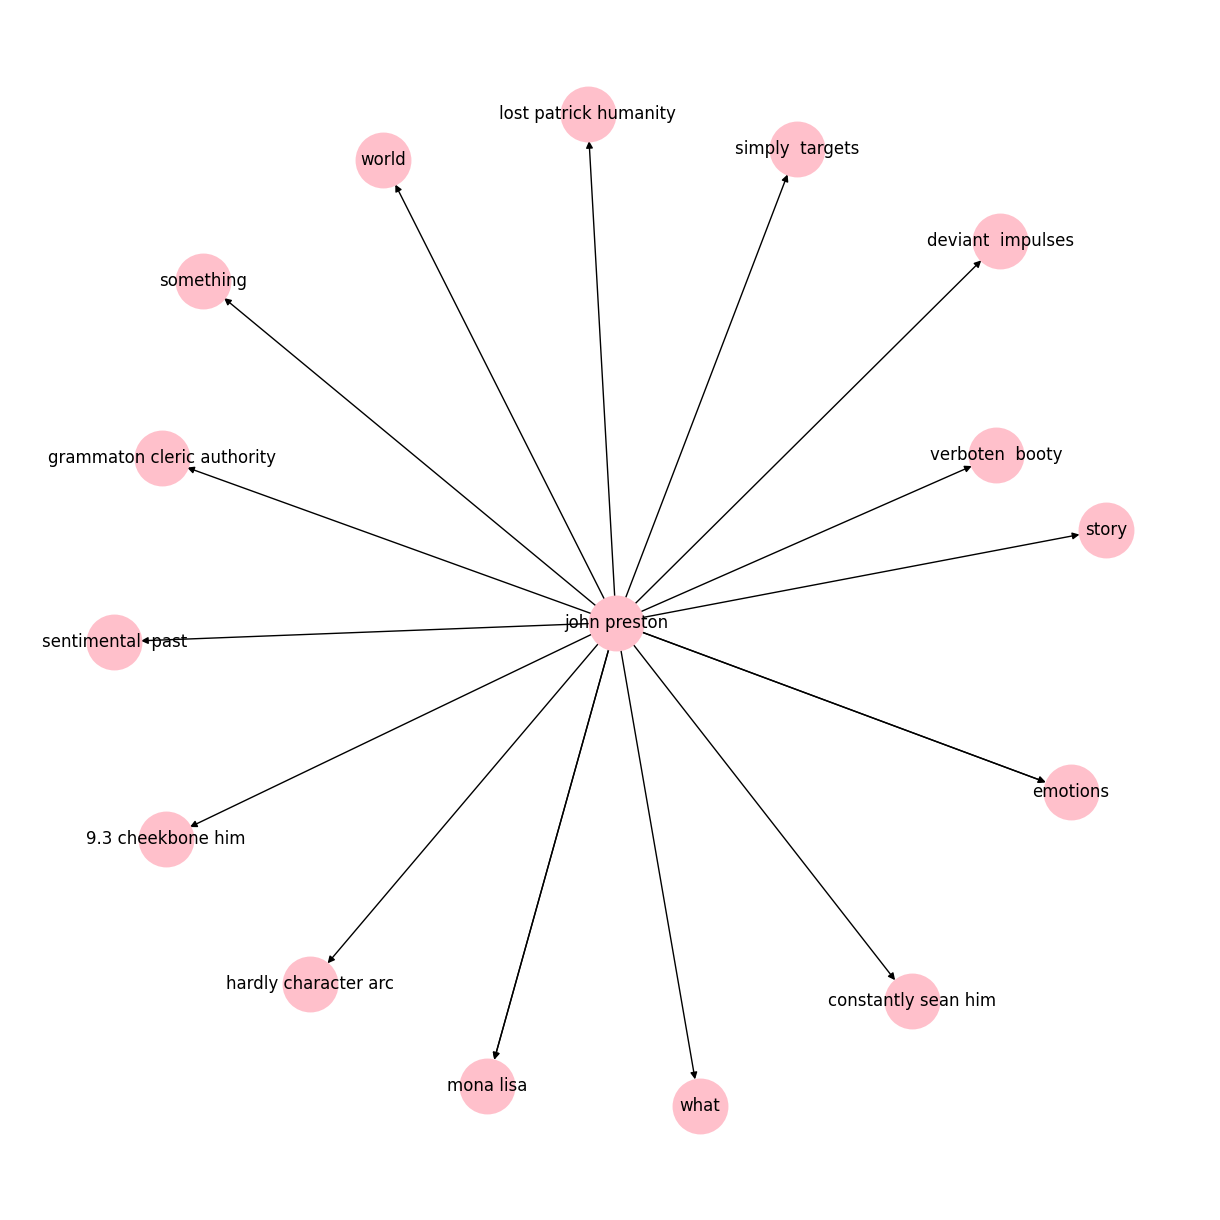

In [71]:
investigate_kg_entities(new_kg_df, ['john preston'])

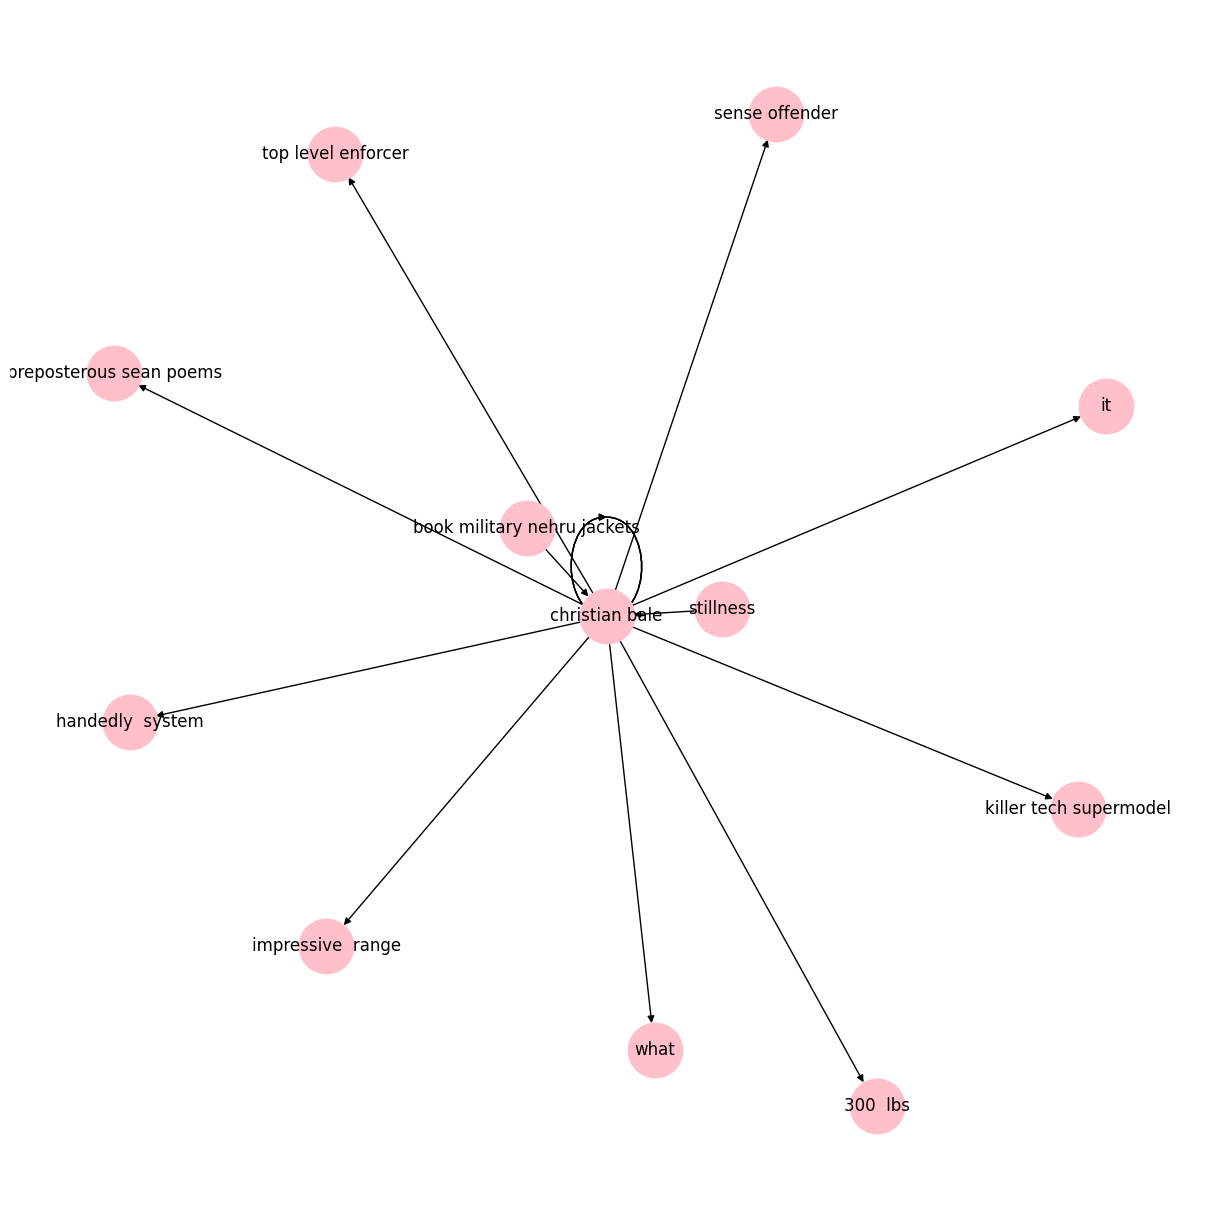

In [72]:
investigate_kg_entities(new_kg_df, ['christian bale'])

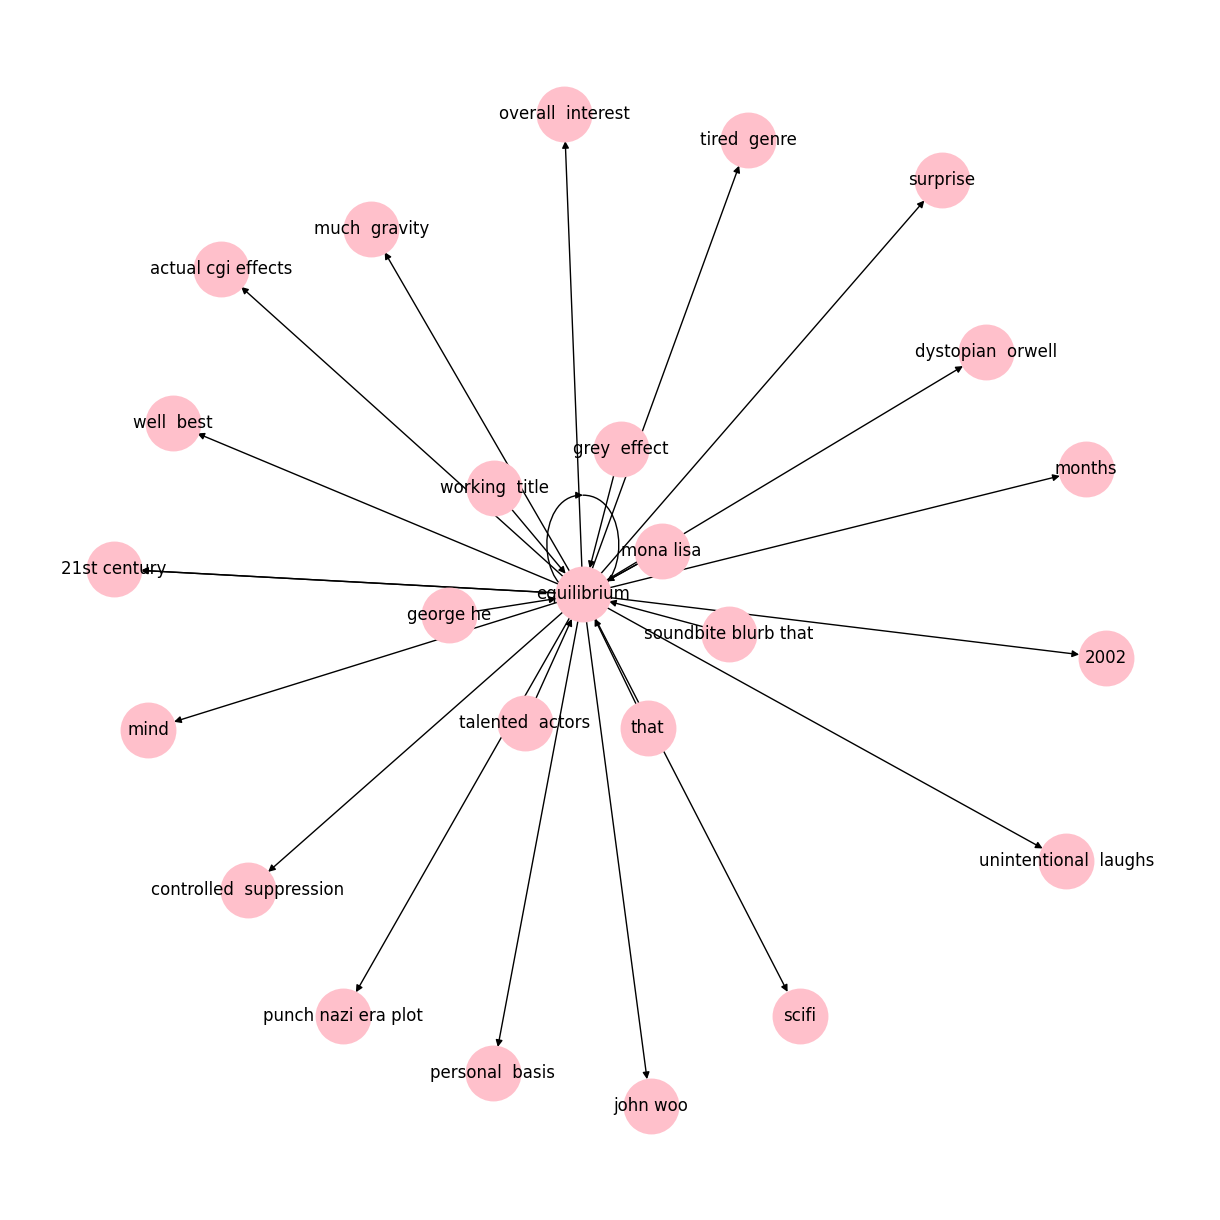

In [73]:
investigate_kg_entities(new_kg_df, ['equilibrium'])

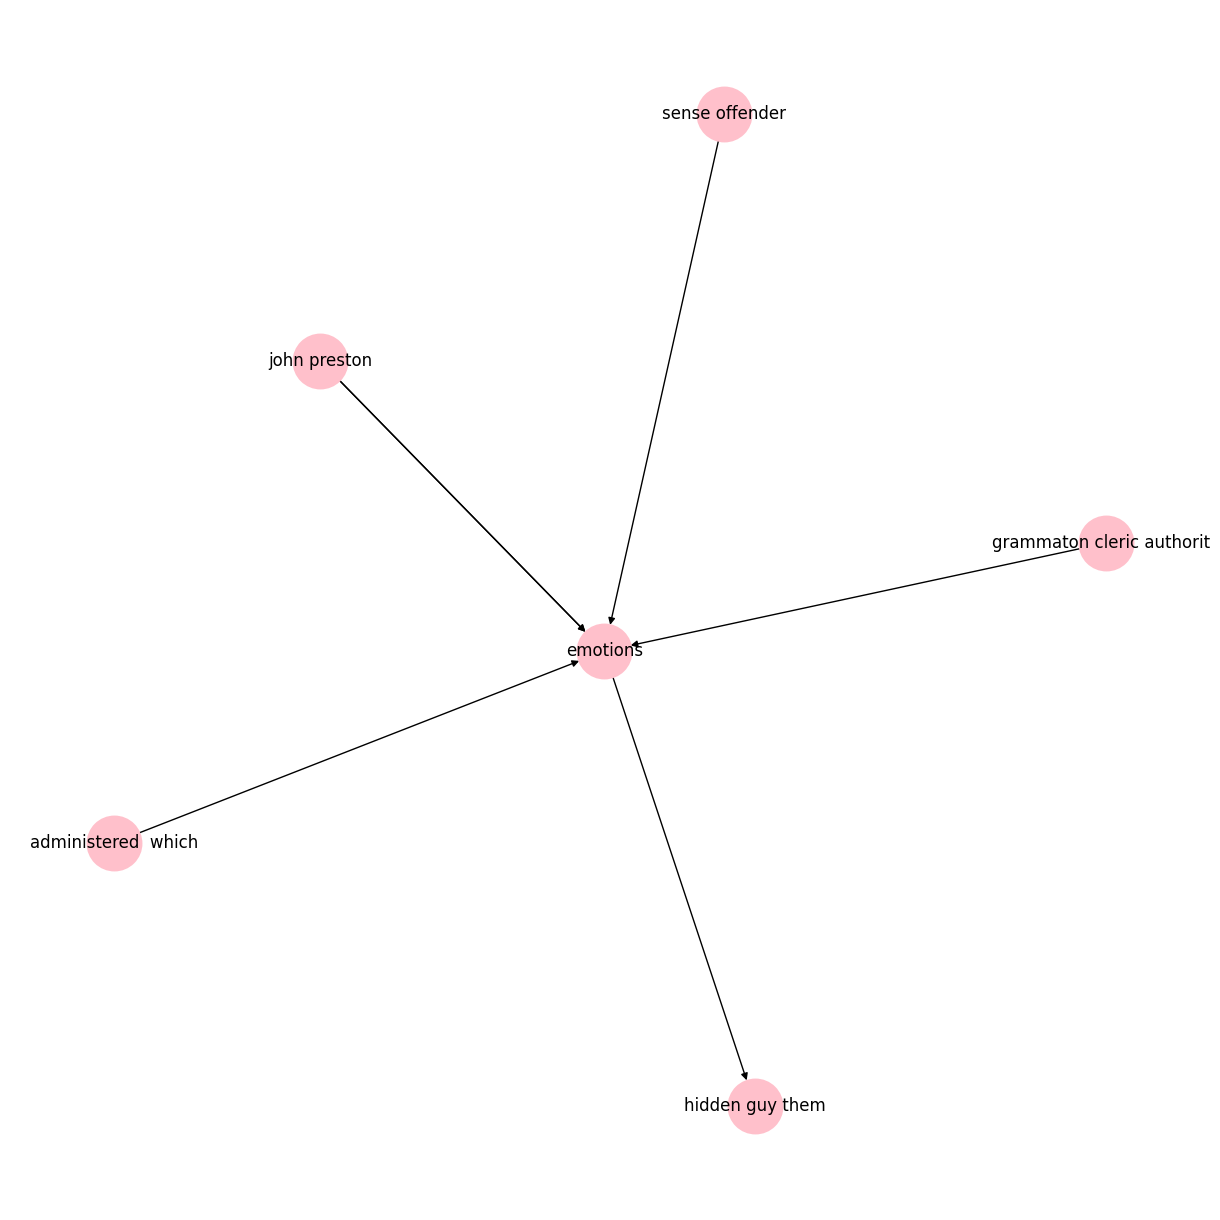

In [74]:
investigate_kg_entities(new_kg_df, ['emotions'])

In [75]:
pd.set_option('display.max_rows', 500)
new_all_entities = new_kg_df['source'].tolist() + new_kg_df['target'].tolist()
new_frequency_count = pd.Series(new_all_entities).value_counts()

In [76]:
new_frequency_count

equilibrium                          28
christian bale                       17
john preston                         17
emotions                              6
mona lisa                             6
fahrenheit                            5
sense offender                        5
that                                  5
prozium                               4
grammaton cleric authority            4
story                                 3
it                                    3
21st century                          3
this                                  3
citizens                              2
what                                  2
2002                                  2
something                             2
world war iii                         2
you                                   2
kurt wimmer                           2
wb yeats                              2
best  soldier                         2
they                                  2
scifi                                 2


Text(0, 0.5, 'Number of Entities')

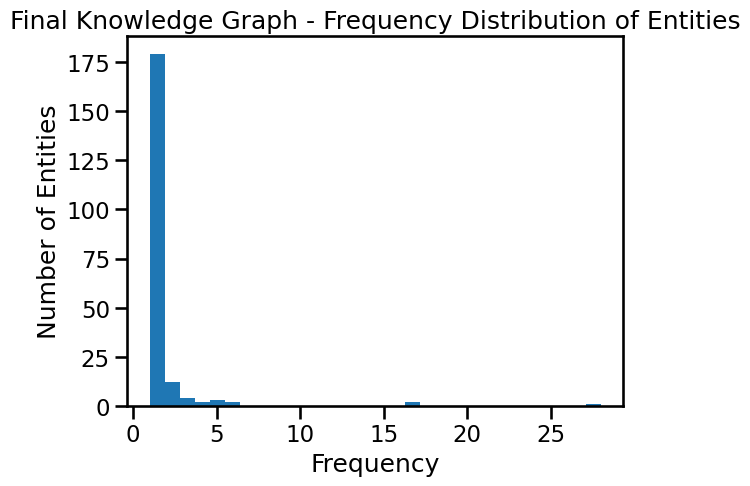

In [77]:
plt.hist(new_frequency_count, bins=30)
plt.title('Final Knowledge Graph - Frequency Distribution of Entities')
plt.xlabel('Frequency')
plt.ylabel('Number of Entities')

In [78]:
print(len(new_frequency_count))

205


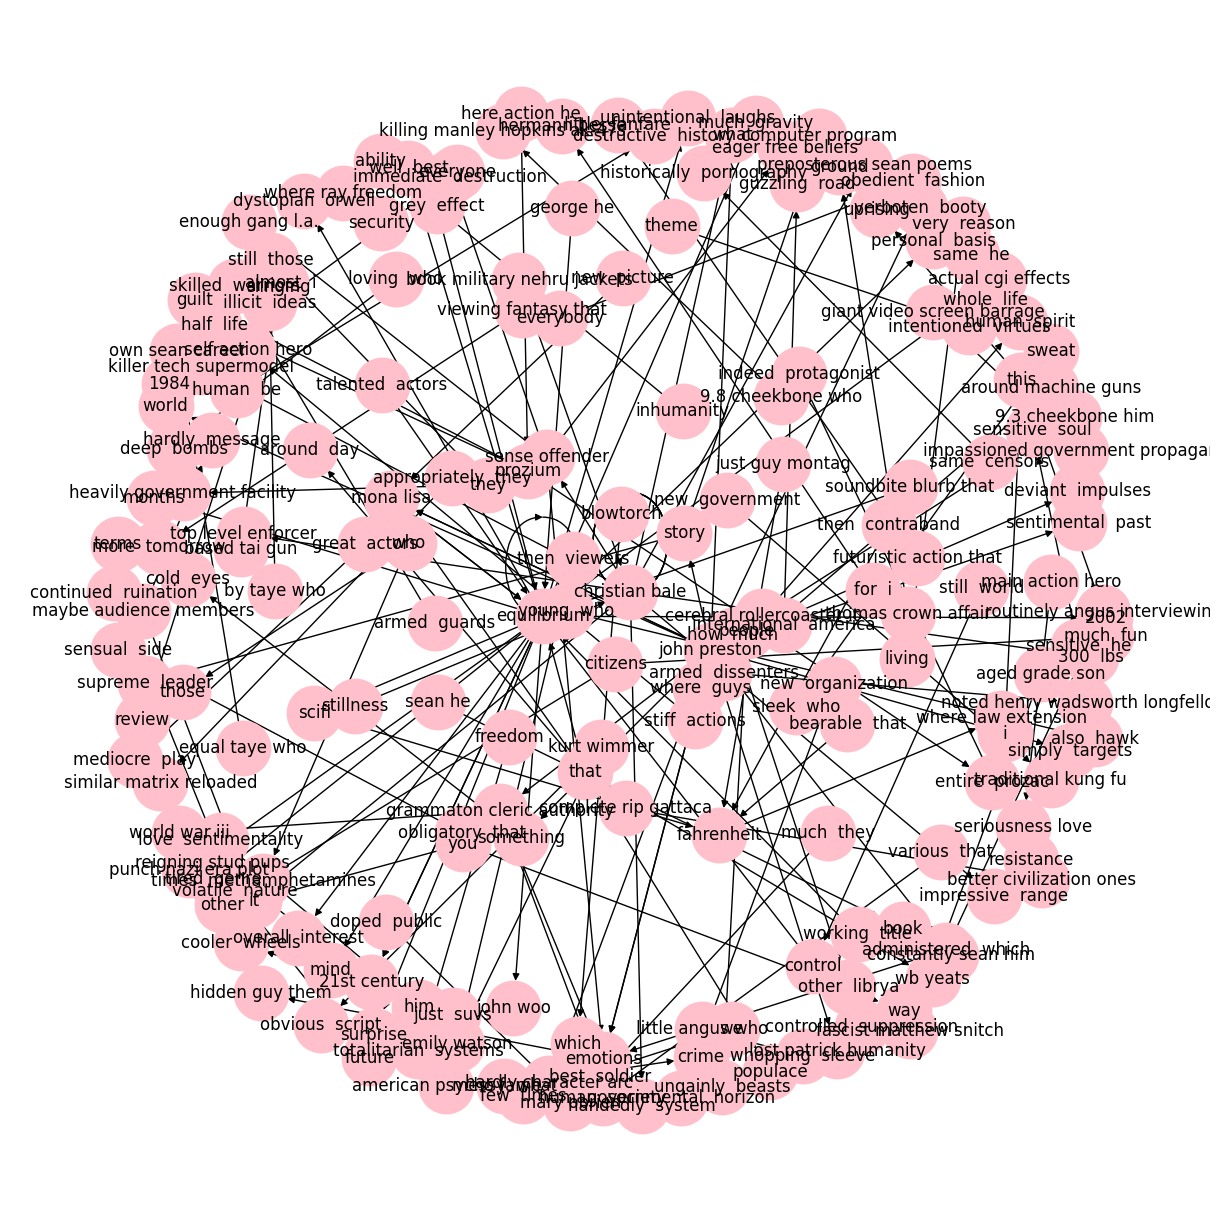

In [79]:
# create a directed-graph from a dataframe
G = nx.from_pandas_edgelist(new_kg_df, "source", "target",
                            edge_attr=True, create_using=nx.MultiDiGraph())


plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes

nx.draw(G, with_labels=True,
        node_color='pink',
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()


# Next Steps

- Identify and merge equivalence classes in the entities extracted.
- Explore few interesting relations and entities.

# Reference

https://www.kaggle.com/code/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk/notebook